### Generate list of sequences from probabilities

The example below uses probabilities given by BLOSUM, but these could easily be replaced by those from AbLang, ESM, ProteinMPNN, or another method.

In [1]:
import os
import sys
import pandas as pd
sys.path.append('../')

from src.utils import (
    get_Trastuzumab_len_10_H3_seq,
    generate_new_seqs_from_probabilities,
    get_observed_frequnecies_from_list_of_seqs,
    make_nice_df_from_seqs,
    join_dfs,
    get_target_edit_distance_counts
)
from src.plotting import (
    plot_logo_plot_from_normalised_matrix,
    plot_edit_distances
)

seq_to_mutate = get_Trastuzumab_len_10_H3_seq()

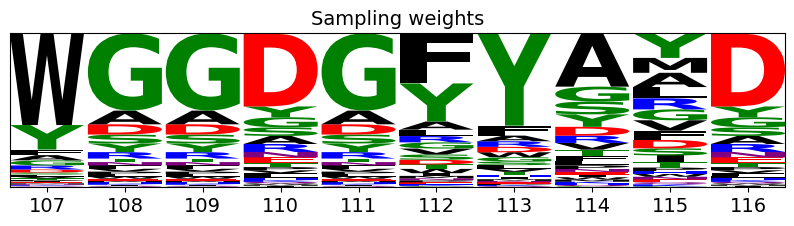

In [2]:
from src.library_design_methods.blosum import (
    get_20x20_blosum_matrix,
    get_blosum_h3_AA_probs,
    get_blosum_probs_for_seq
)

blosum_matrix      = get_20x20_blosum_matrix(45)
blosum_h3_AA_probs = get_blosum_h3_AA_probs()
sampling_probs     = get_blosum_probs_for_seq(seq_to_mutate, blosum_matrix, blosum_h3_AA_probs)
plot_logo_plot_from_normalised_matrix(sampling_probs, title="Sampling weights")

### Generate sequences from probability distribution

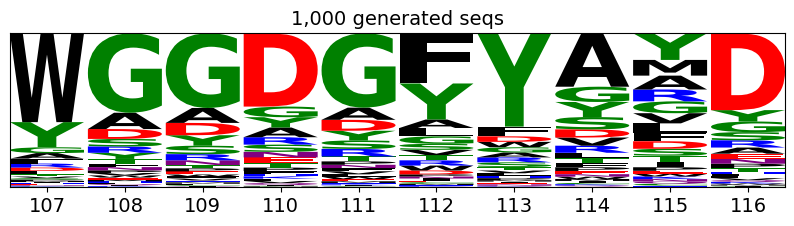

First 5 generated sequences:


,seq,edit_distance
0,WGGDARFRGG,6
1,RGAYAYYYND,7
2,GGADRYVGED,7
3,WGAYGISFME,6
4,WGSSSFTLMY,6


In [3]:
# rerunning this cell multiple times will generate different sequences
num_new_seqs_to_generate = 1000
new_library = generate_new_seqs_from_probabilities(sampling_probs, num_new_seqs_to_generate)
new_library_df = make_nice_df_from_seqs(new_library, original_seq=seq_to_mutate)

new_library_freqs = get_observed_frequnecies_from_list_of_seqs(new_library)
plot_logo_plot_from_normalised_matrix(new_library_freqs, title=f"{num_new_seqs_to_generate:,} generated seqs")

print("First 5 generated sequences:")
new_library_df.head()

### Generate sequences from probability distribution with desired distribution of edit distances

If we have a starting sequence that binds, we are more likely to want to explore small to medium edit distances (number of mutations) from this. Some LLMs tend to generate sequences with large edit distances, so it is useful to filter these. This is also important when comparing the binding enrichments of libraries designed using different methods

In [4]:
# say we wish to match the edit distance of some experimental positive data
data = os.path.abspath("../data/affinity_data/her2/her2_aff_large/processed/remove_overlap/random_split/0.7_0.15_0.15/")
train = pd.read_csv(os.path.join(data, "train.csv"))
val = pd.read_csv(os.path.join(data, "val.csv"))
test = pd.read_csv(os.path.join(data, "test.csv"))
experimental_data = join_dfs([train, val, test])

# note, you could instead simply specify how many sequences you want to generate at each edit distance
target_counts = get_target_edit_distance_counts(experimental_data, target_total=num_new_seqs_to_generate, positives_only=True)
print(f"Observed edit distance distribution scaled to target total:\n{dict(sorted(target_counts.items()))}")

experimental_data.sample(5)


Observed edit distance distribution scaled to target total:
{1: 0, 2: 3, 3: 8, 4: 28, 5: 98, 6: 220, 7: 313, 8: 235, 9: 77, 10: 18}


,seq,class,label,edit_distance
2029,WMLSGSSDYS,mid,0,8
37632,WSTFAIYDFH,low,0,8
68750,WDDARFYSYD,high,1,6
214768,WGGARFYSFE,high,1,5
253548,TLLRLFTLYT,high,1,9


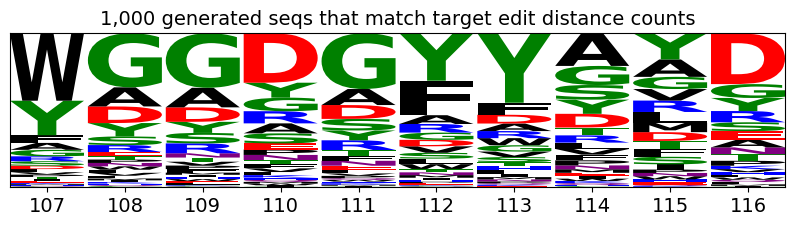

In [5]:
num_new_seqs_to_generate = 1000
max_tries=10000
new_library_match_target_counts = generate_new_seqs_from_probabilities(sampling_probs, num_new_seqs_to_generate, target_counts=target_counts,
                                                                       max_tries=max_tries, original_seq=seq_to_mutate)
new_library_match_target_counts_df = make_nice_df_from_seqs(new_library_match_target_counts, original_seq=seq_to_mutate)

new_library_match_target_counts_freqs = get_observed_frequnecies_from_list_of_seqs(new_library_match_target_counts)
plot_logo_plot_from_normalised_matrix(new_library_match_target_counts_freqs, title=f"{num_new_seqs_to_generate:,} generated seqs that match target edit distance counts")

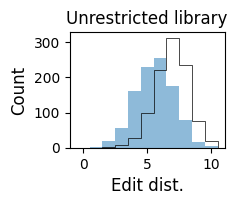

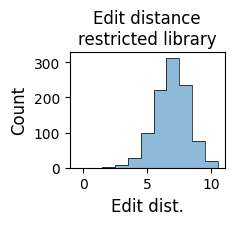

In [6]:
# compare edit distances distributions of the two libraries
plot_edit_distances(new_library_df, target_counts=target_counts, title="Unrestricted library")
plot_edit_distances(new_library_match_target_counts_df, target_counts=target_counts, title="Edit distance\nrestricted library")